In [ ]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pilot_academy.data.io import read_fn
import tensorflow as tf
from typing import Iterable, Tuple
import matplotlib.patches as mpatches

In [5]:
# Paths
PROJECT_DIR = Path("/workspaces/pilot_academy")
DATA_DIR = PROJECT_DIR / "data" / "all_towns_with_weather" / "raw"
RUN_DIR = PROJECT_DIR / "outputs" / "2026-01-27" / "23-03-28_command_vit_baseline"
IMAGES_DIR = DATA_DIR / "images"

df_path = DATA_DIR / "df_annotations.csv"
label_to_id_path = DATA_DIR / "label_to_id.json"
action_to_id_path = DATA_DIR / "action_to_id.json"
model_path = RUN_DIR / "checkpoints" / "model.keras"

In [8]:
# Load annotations
df_annotations = pd.read_csv(df_path)

# Load mappings
with open(action_to_id_path) as f:
    action_to_id = json.load(f)

with open(label_to_id_path) as f:
    label_to_id = {
        tuple(k.split("|")): int(v)
        for k, v in json.load(f).items()
    }

# Collect images
image_paths = sorted(IMAGES_DIR.glob("*.png"))

# map filename -> full path
paths_by_name = {p.name: p for p in image_paths}

needed = set(df_annotations["image_name"])
available = set(paths_by_name.keys())

missing = needed - available
if missing:
    raise FileNotFoundError(
        f"{len(missing)} missing image(s). First: {next(iter(missing))}"
    )

# Load model
model = tf.keras.models.load_model(model_path)
print(f"Model loaded: {model.name}")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

Model loaded: command_vit
Input shape: [(None, 120, 220, 1), (None,)]
Output shape: (None, 1)


In [7]:
df_annotations.head()

,frame_index,timestamp_ns,timestamp_sec,timestamp_nsec,frame_id,steering_angle,event_id,road_context,driver_action,town,class_id,image_name
0,0,0,0,0,carla_camera,-0.003080,evt_0e8fMt5zIKFzxiMA,straight,follow_road,town_01,9,image000000000.png
1,1,50000000,0,50000000,carla_camera,-0.003918,evt_0e8fMt5zIKFzxiMA,straight,follow_road,town_01,9,image000000001.png
2,2,100000000,0,100000000,carla_camera,-0.002310,evt_0e8fMt5zIKFzxiMA,straight,follow_road,town_01,9,image000000002.png
3,3,150000000,0,150000000,carla_camera,0.001623,evt_0e8fMt5zIKFzxiMA,straight,follow_road,town_01,9,image000000003.png
4,4,200000000,0,200000000,carla_camera,0.004177,evt_0e8fMt5zIKFzxiMA,straight,follow_road,town_01,9,image000000004.png


In [13]:
def select_event_window_covering_classes(
    df: pd.DataFrame,
    num_classes: int,
    event_col: str = "event_id",
    class_col: str = "class_id",
):
    """
    Find the smallest contiguous window of events covering num_classes distinct classes.
    Returns all frames from the selected events.
    
    Example:
        >>> test_df = select_event_window_covering_classes(df, num_classes=5)
        >>> print(f"{len(test_df)} frames from {test_df.event_id.nunique()} events")
    """
    # Get one row per event (preserving order)
    events = df[[event_col, class_col]].drop_duplicates(event_col).reset_index(drop=True)
    
    # Sliding window to find smallest sequence with num_classes
    best_window = None
    left = 0
    class_counts = {}
    
    for right in range(len(events)):
        # Add event at right
        cls = events.loc[right, class_col]
        class_counts[cls] = class_counts.get(cls, 0) + 1
        
        # Shrink from left while we still have enough classes
        while len(class_counts) >= num_classes:
            # Update best window
            window_size = right - left + 1
            if best_window is None or window_size < best_window[0]:
                best_window = (window_size, left, right)
            
            # Try removing leftmost event
            left_cls = events.loc[left, class_col]
            class_counts[left_cls] -= 1
            if class_counts[left_cls] == 0:
                del class_counts[left_cls]
            left += 1
    
    if best_window is None:
        raise ValueError(f"Could not find {num_classes} distinct classes")
    
    # Extract all frames from selected events
    _, left, right = best_window
    selected_events = events.loc[left:right, event_col].tolist()
    result = df[df[event_col].isin(selected_events)].copy()
    
    print(f"Selected {len(selected_events)} events → {len(result)} frames")
    print(f"Classes: {result[class_col].nunique()} distinct")
    
    return result



In [24]:
test_df = select_event_window_covering_classes(df_annotations, num_classes=9)

Selected 15 events → 1442 frames
Classes: 9 distinct


Images shape: (1442, 120, 220, 1)
Commands shape: (1442,)
Ground truth shape: (1442,)
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Mean Absolute Error: 0.051805


/tmp/ipykernel_3522/946435507.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(1, len(unique_classes)))


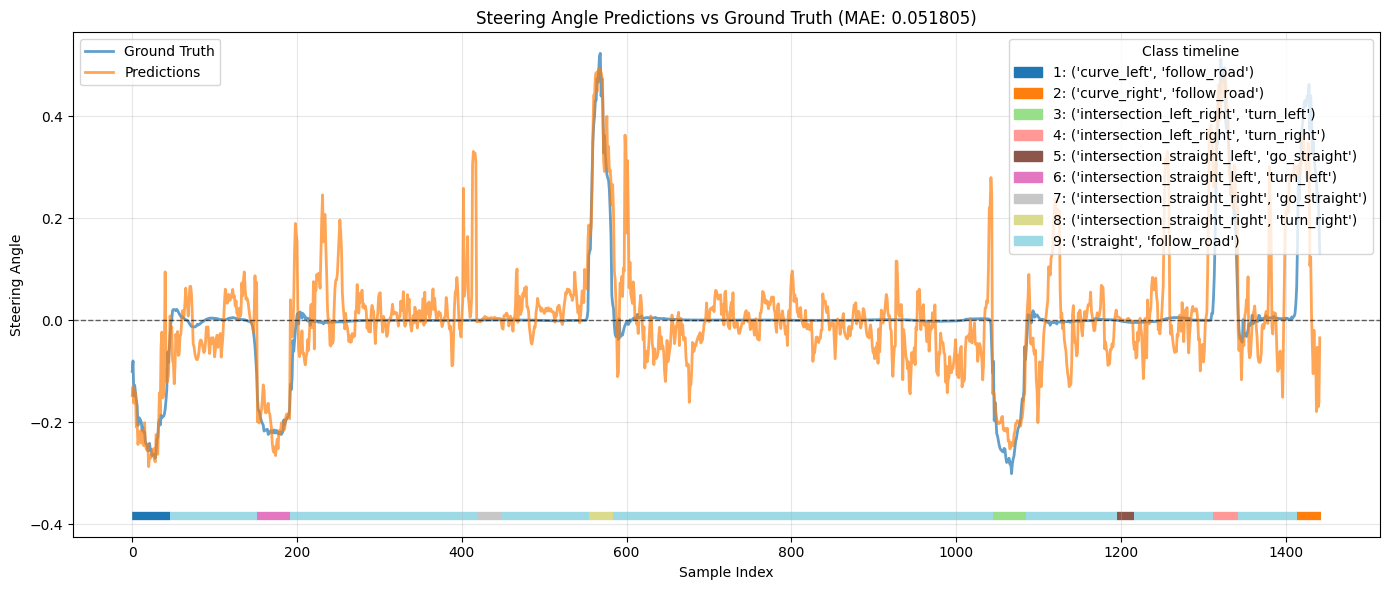

In [ ]:
# Configuration
crop_ymin = 100
grayscale = True

# Prepare data
images = []
commands = []
ground_truth = []
classes = []

for _, row in test_df.iterrows():
    img_path = image_paths[row.name]
    img = read_fn(str(img_path), grayscale=grayscale, crop_ymin=crop_ymin)
    images.append(img)

    commands.append(action_to_id[row["driver_action"]])
    ground_truth.append(row["steering_angle"])
    classes.append(int(row["class_id"]))

images = np.array(images, dtype=np.float32)
commands = np.array(commands, dtype=np.int32)
ground_truth = np.array(ground_truth, dtype=np.float32)
classes = np.array(classes, dtype=np.int32)

print(f"Images shape: {images.shape}")
print(f"Commands shape: {commands.shape}")
print(f"Ground truth shape: {ground_truth.shape}")

# Run prediction
predictions = model.predict([images, commands], batch_size=32, verbose=1).squeeze()

# Calculate MAE
mae = float(np.mean(np.abs(predictions - ground_truth)))
print(f"\nMean Absolute Error: {mae:.6f}")

# ---- Build class segments (contiguous runs) ----
segments = []
start_idx = 0
for i in range(1, len(classes)):
    if classes[i] != classes[i - 1]:
        segments.append((start_idx, i, int(classes[i - 1])))
        start_idx = i
segments.append((start_idx, len(classes), int(classes[-1])))

unique_classes = sorted(np.unique(classes).tolist())

# More robust than tab10 if you have many classes
cmap = plt.cm.get_cmap("tab20", max(1, len(unique_classes)))
class_to_color = {cid: cmap(i) for i, cid in enumerate(unique_classes)}

# id -> label (label_to_id is label -> id)
id_to_label = {v: k for k, v in label_to_id.items()}

# ---- Plot ----
fig, ax = plt.subplots(figsize=(14, 6))

# Main signals
ax.plot(ground_truth, label="Ground Truth", alpha=0.7, linewidth=2)
ax.plot(predictions, label="Predictions", alpha=0.7, linewidth=2)

# Timeline position (below data)
y_min = float(min(ground_truth.min(), predictions.min()))
y_max = float(max(ground_truth.max(), predictions.max()))
y_range = max(1e-6, y_max - y_min)
timeline_y = y_min - 0.10 * y_range

# Draw colored timeline
for s, e, cid in segments:
    ax.plot(
        [s, e],
        [timeline_y, timeline_y],
        color=class_to_color[cid],
        linewidth=6,
        solid_capstyle="butt",
        zorder=1,
    )

# ---- Vertical grid lines at segment boundaries ----
for s, _, _ in segments:
    ax.axvline(
        x=s,
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.25,
        zorder=0,
    )

# Also mark the very end
ax.axvline(
    x=len(classes),
    color="gray",
    linestyle="--",
    linewidth=0.8,
    alpha=0.25,
    zorder=0,
)

# Axis limits so timeline is visible
ax.set_ylim(timeline_y - 0.05 * y_range, y_max + 0.05 * y_range)

ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.6)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Steering Angle")
ax.set_title(f"Steering Angle Predictions vs Ground Truth (MAE: {mae:.6f})")
ax.grid(True, axis="y", alpha=0.3)

# Legends
leg1 = ax.legend(loc="upper left")

handles = [
    mpatches.Patch(
        color=class_to_color[cid],
        label=f"{cid}: {id_to_label.get(cid, str(cid))}",
    )
    for cid in unique_classes
]
leg2 = ax.legend(handles=handles, title="Class timeline", loc="upper right")
ax.add_artist(leg1)

plt.tight_layout()
plt.savefig(RUN_DIR / "test_predictions.png", dpi=150)
plt.show()


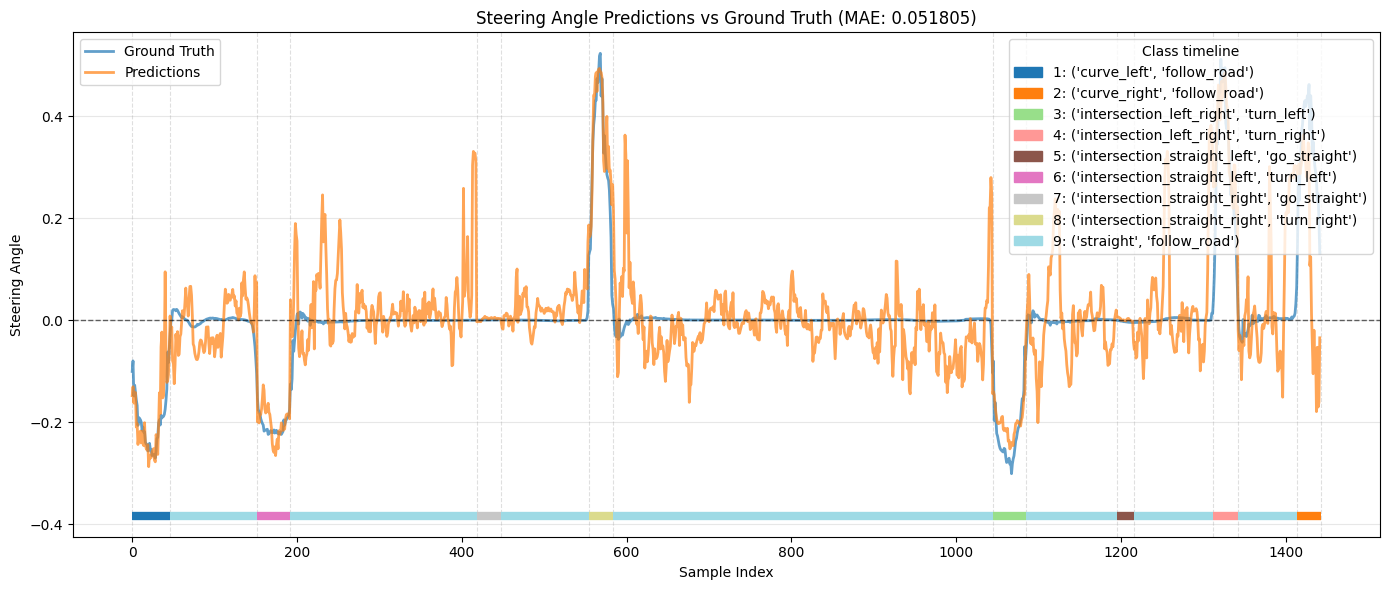

In [26]:
# ---- Plot ----
fig, ax = plt.subplots(figsize=(14, 6))

# Main signals
ax.plot(ground_truth, label="Ground Truth", alpha=0.7, linewidth=2)
ax.plot(predictions, label="Predictions", alpha=0.7, linewidth=2)

# Timeline position (below data)
y_min = float(min(ground_truth.min(), predictions.min()))
y_max = float(max(ground_truth.max(), predictions.max()))
y_range = max(1e-6, y_max - y_min)
timeline_y = y_min - 0.10 * y_range

# Draw colored timeline
for s, e, cid in segments:
    ax.plot(
        [s, e],
        [timeline_y, timeline_y],
        color=class_to_color[cid],
        linewidth=6,
        solid_capstyle="butt",
        zorder=1,
    )

# ---- Vertical grid lines at segment boundaries ----
for s, _, _ in segments:
    ax.axvline(
        x=s,
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.25,
        zorder=0,
    )

# Also mark the very end
ax.axvline(
    x=len(classes),
    color="gray",
    linestyle="--",
    linewidth=0.8,
    alpha=0.25,
    zorder=0,
)

# Axis limits so timeline is visible
ax.set_ylim(timeline_y - 0.05 * y_range, y_max + 0.05 * y_range)

ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.6)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Steering Angle")
ax.set_title(f"Steering Angle Predictions vs Ground Truth (MAE: {mae:.6f})")
ax.grid(True, axis="y", alpha=0.3)

# Legends
leg1 = ax.legend(loc="upper left")

handles = [
    mpatches.Patch(
        color=class_to_color[cid],
        label=f"{cid}: {id_to_label.get(cid, str(cid))}",
    )
    for cid in unique_classes
]
leg2 = ax.legend(handles=handles, title="Class timeline", loc="upper right")
ax.add_artist(leg1)

plt.tight_layout()
plt.savefig(RUN_DIR / "test_predictions.png", dpi=150)
plt.show()


In [18]:
def create_balanced_test_set(
    df_annotations,
    n_samples_per_class=500,
    class_col="class_id",
    random_state=42
):
    """
    Create a balanced test set by sampling n_samples from each class.
    
    Args:
        df_annotations: Full dataframe with all annotations
        n_samples_per_class: Number of samples to draw from each class
        class_col: Column name for class labels
        random_state: Random seed for reproducibility
        
    Returns:
        DataFrame with balanced test samples
    """
    np.random.seed(random_state)
    
    test_samples = []
    
    for class_id in sorted(df_annotations[class_col].unique()):
        class_df = df_annotations[df_annotations[class_col] == class_id]
        n = min(n_samples_per_class, len(class_df))
        sampled = class_df.sample(n=n, random_state=random_state + class_id)
        test_samples.append(sampled)
        
        print(f"Class {class_id}: sampled {n}/{len(class_df)} samples")
    
    test_df = pd.concat(test_samples, ignore_index=False)
    
    print(f"\nTotal test samples: {len(test_df)}")
    print(f"Classes: {test_df[class_col].nunique()}")
    
    return test_df


def evaluate_per_class(
    test_df,
    predictions,
    ground_truth,
    label_to_id,
    class_col="class_id",
    save_path=None
):
    """
    Evaluate model performance per class and create visualization.
    
    Args:
        test_df: Test dataframe with class labels
        predictions: Model predictions
        ground_truth: Ground truth steering angles
        label_to_id: Mapping from (road_context, driver_action) to class_id
        class_col: Column name for class labels
        save_path: Optional path to save the plot
        
    Returns:
        DataFrame with per-class metrics
    """
    id_to_label = {v: k for k, v in label_to_id.items()}
    errors = np.abs(predictions - ground_truth)
    
    test_df_eval = test_df.copy()
    test_df_eval['prediction'] = predictions
    test_df_eval['ground_truth'] = ground_truth
    test_df_eval['abs_error'] = errors
    
    class_metrics = []
    
    for class_id in sorted(test_df[class_col].unique()):
        class_mask = test_df_eval[class_col] == class_id
        class_errors = errors[class_mask]
        
        if class_id in id_to_label:
            road_context, driver_action = id_to_label[class_id]
            label = f"{road_context} | {driver_action}"
        else:
            label = f"Class {class_id}"
        
        mae = np.mean(class_errors)
        std = np.std(class_errors)
        rmse = np.sqrt(np.mean(class_errors ** 2))
        n_samples = len(class_errors)
        
        class_metrics.append({
            'class_id': class_id,
            'label': label,
            'n_samples': n_samples,
            'mae': mae,
            'std': std,
            'rmse': rmse,
        })
    
    metrics_df = pd.DataFrame(class_metrics)
    
    print("\nPer-Class Performance:")
    print("=" * 80)
    for _, row in metrics_df.iterrows():
        print(f"{row['label']:40s} (n={row['n_samples']:4d}): "
              f"MAE={row['mae']:.6f}, RMSE={row['rmse']:.6f}, STD={row['std']:.6f}")
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    ax1 = axes[0]
    x = np.arange(len(metrics_df))
    bars = ax1.bar(x, metrics_df['mae'], yerr=metrics_df['std'], 
                    capsize=5, alpha=0.7, color='steelblue')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Mean Absolute Error')
    ax1.set_title('Per-Class MAE with Standard Deviation')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"{row['class_id']}" for _, row in metrics_df.iterrows()], 
                         rotation=0)
    ax1.grid(True, alpha=0.3, axis='y')
    
    worst_idx = metrics_df['mae'].nlargest(3).index
    for idx in worst_idx:
        bars[idx].set_color('red')
        bars[idx].set_alpha(0.9)
    
    ax2 = axes[1]
    ax2_twin = ax2.twinx()
    
    ax2.bar(x - 0.2, metrics_df['n_samples'], width=0.4, 
            alpha=0.7, color='lightgreen', label='Sample Count')
    ax2_twin.bar(x + 0.2, metrics_df['rmse'], width=0.4,
                 alpha=0.7, color='coral', label='RMSE')
    
    ax2.set_xlabel('Class ID')
    ax2.set_ylabel('Sample Count', color='green')
    ax2_twin.set_ylabel('RMSE', color='coral')
    ax2.set_title('Sample Distribution and RMSE per Class')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f"{row['class_id']}" for _, row in metrics_df.iterrows()],
                         rotation=0)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\nPlot saved to: {save_path}")
    
    plt.show()
    
    return metrics_df

In [19]:
# Cell 2: Create balanced test set
test_df = create_balanced_test_set(df_annotations, n_samples_per_class=500)

Class 1: sampled 500/1135 samples
Class 2: sampled 500/1185 samples
Class 3: sampled 500/1005 samples
Class 4: sampled 500/1180 samples
Class 5: sampled 500/570 samples
Class 6: sampled 500/1082 samples
Class 7: sampled 500/1622 samples
Class 8: sampled 500/1176 samples
Class 9: sampled 500/44144 samples

Total test samples: 4500
Classes: 9


In [20]:
# Cell 3: Load and prepare data
crop_ymin = 100
grayscale = True

images = []
commands = []
ground_truth = []

for _, row in test_df.iterrows():
    img_path = image_paths[row.name]
    img = read_fn(str(img_path), grayscale=grayscale, crop_ymin=crop_ymin)
    images.append(img)
    
    command_id = action_to_id[row['driver_action']]
    commands.append(command_id)
    
    ground_truth.append(row['steering_angle'])

images = np.array(images, dtype=np.float32)
commands = np.array(commands, dtype=np.int32)
ground_truth = np.array(ground_truth, dtype=np.float32)

print(f"Images shape: {images.shape}")
print(f"Commands shape: {commands.shape}")
print(f"Ground truth shape: {ground_truth.shape}")

Images shape: (4500, 120, 220, 1)
Commands shape: (4500,)
Ground truth shape: (4500,)


In [21]:
# Cell 4: Run predictions
predictions = model.predict([images, commands], batch_size=32, verbose=1)
predictions = predictions.squeeze()

overall_mae = np.mean(np.abs(predictions - ground_truth))
print(f"Overall MAE: {overall_mae:.6f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
Overall MAE: 0.045983



Per-Class Performance:
curve_left | follow_road                 (n= 500): MAE=0.046490, RMSE=0.065951, STD=0.046779
curve_right | follow_road                (n= 500): MAE=0.068357, RMSE=0.095277, STD=0.066370
intersection_left_right | turn_left      (n= 500): MAE=0.040278, RMSE=0.058903, STD=0.042979
intersection_left_right | turn_right     (n= 500): MAE=0.067950, RMSE=0.092600, STD=0.062909
intersection_straight_left | go_straight (n= 500): MAE=0.004165, RMSE=0.005158, STD=0.003042
intersection_straight_left | turn_left   (n= 500): MAE=0.041912, RMSE=0.056366, STD=0.037690
intersection_straight_right | go_straight (n= 500): MAE=0.005702, RMSE=0.007367, STD=0.004665
intersection_straight_right | turn_right (n= 500): MAE=0.072744, RMSE=0.101350, STD=0.070570
straight | follow_road                   (n= 500): MAE=0.066251, RMSE=0.099114, STD=0.073719



Plot saved to: /workspaces/pilot_academy/outputs/2026-01-27/23-03-28_command_vit_baseline/per_class_evaluation.png


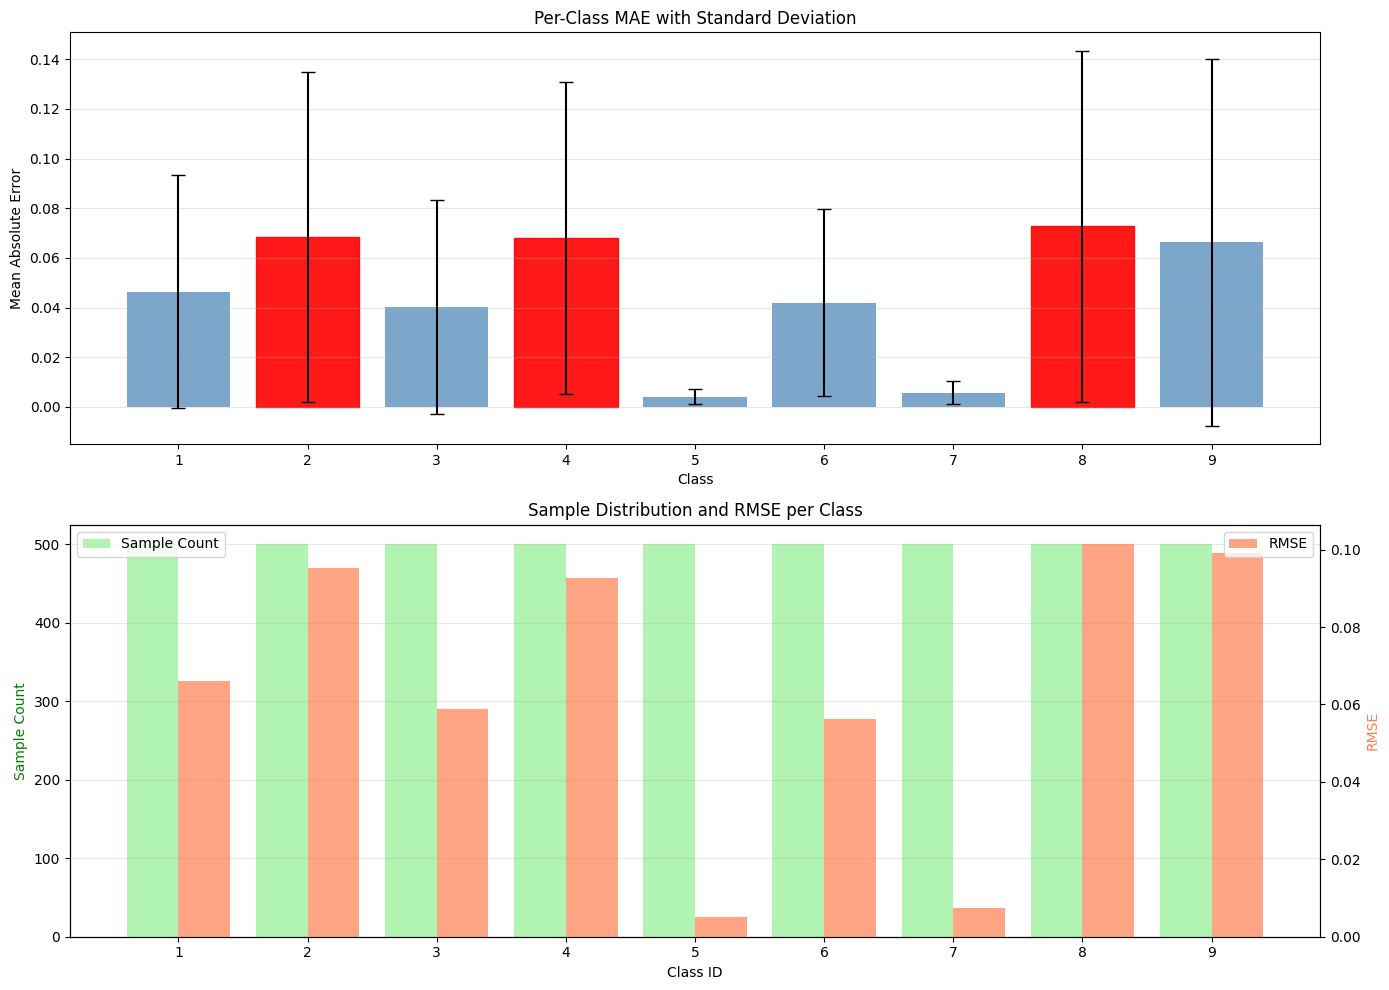

In [22]:
# Cell 5: Evaluate per class
metrics_df = evaluate_per_class(
    test_df,
    predictions,
    ground_truth,
    label_to_id,
    save_path=RUN_DIR / 'per_class_evaluation.png'
)

In [23]:
# Cell 6: Show worst performing classes
print("Top 5 worst performing classes:")
metrics_df.nlargest(5, 'mae')[['label', 'n_samples', 'mae', 'rmse']]

Top 5 worst performing classes:


,label,n_samples,mae,rmse
7,intersection_straight_right | turn_right,500,0.072744,0.101350
1,curve_right | follow_road,500,0.068357,0.095277
3,intersection_left_right | turn_right,500,0.067950,0.092600
8,straight | follow_road,500,0.066251,0.099114
0,curve_left | follow_road,500,0.046490,0.065951


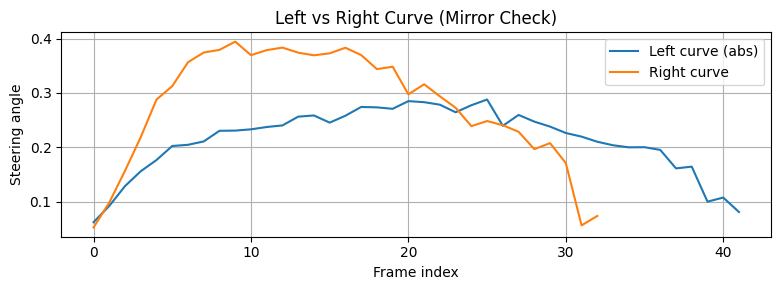

In [30]:
# ------------------------------------------------------------
# Pick one event per class
# ------------------------------------------------------------
left_event_id = (
    df_annotations.loc[df_annotations["class_id"] == 1, "event_id"]
    .iloc[0]
)

right_event_id = (
    df_annotations.loc[df_annotations["class_id"] == 2, "event_id"]
    .iloc[0]
)

# ------------------------------------------------------------
# Extract full steering sequences
# ------------------------------------------------------------
left_seq = df_annotations.loc[
    df_annotations["event_id"] == left_event_id, "steering_angle"
].to_numpy()

right_seq = df_annotations.loc[
    df_annotations["event_id"] == right_event_id, "steering_angle"
].to_numpy()

# Mirror left curve
left_seq_mirror = np.abs(left_seq)

# ------------------------------------------------------------
# Compare
# ------------------------------------------------------------
plt.figure(figsize=(8, 3))
plt.plot(left_seq_mirror, label="Left curve (abs)")
plt.plot(right_seq, label="Right curve")
plt.xlabel("Frame index")
plt.ylabel("Steering angle")
plt.title("Left vs Right Curve (Mirror Check)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
df_annotations["class_id"].value_counts().sort_index()

class_id
1     1135
2     1185
3     1005
4     1180
5      570
6     1082
7     1622
8     1176
9    44144
Name: count, dtype: int64

In [5]:
from pilot_academy.data.split import balanced_random_train_val_split

In [6]:
SPLIT_DIR = DATA_DIR.parent / "splits"

class_ids = [
 label_to_id[('curve_left', 'follow_road')],
 label_to_id[('curve_right', 'follow_road')],
 label_to_id[('straight', 'follow_road')]
]

train_df, val_df, max_train_samples_per_class, out_dir = \
    balanced_random_train_val_split(df_annotations, class_ids, save_dir=SPLIT_DIR)

In [7]:
from pilot_academy.data.tfdata import make_val_dataset
from pilot_academy.data.cache import cache_events

In [13]:
VAL_PATH = '/workspaces/pilot_academy/data/all_towns_with_weather/splits/split_20260126_201533/df_val.csv'
df_val = pd.read_csv(VAL_PATH, index_col="frame_index")
IMAGE_SHAPE = (120,220,1)
H,W,C = IMAGE_SHAPE
BATCH_SIZE=3
STRAIGHT_CLASS_ID = label_to_id[("straight", "follow_road")]

cache = cache_events(df_val, image_paths, STRAIGHT_CLASS_ID, read_fn)

Caching non-straight events:   0%|          | 0/454 [00:00<?, ?image/s]

Caching non-straight events: 100%|██████████| 454/454 [00:20<00:00, 22.58image/s]


In [60]:
val_ds, val_steps = make_val_dataset(
    df_val=df_val,
    cache=cache,
    image_paths=image_paths,
    action_to_id=action_to_id,
    read_fn=read_fn,
    H=H,
    W=W,
    C=C,
    batch_size=BATCH_SIZE,
)

In [18]:
df_val = pd.read_csv(VAL_PATH)

for frame_index, row in df_val.iterrows():
    print(frame_index)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Loading validation data...
Images shape: (681, 120, 220, 1)
Commands shape: (681,)
Steering angles shape: (681,)

Running predictions...
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step

I0000 00:00:1769515060.814880   73590 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step

Overall MAE: 0.217435

Per-Class Performance:
curve_left | follow_road                      (n=  227): MAE=0.230330, RMSE=0.292643, STD=0.180521
curve_right | follow_road                     (n=  227): MAE=0.277746, RMSE=0.327719, STD=0.173945
straight | follow_road                        (n=  227): MAE=0.144228, RMSE=0.169376, STD=0.088807

Top 5 WORST performing classes:
curve_right | follow_road                    : MAE=0.277746
curve_left | follow_road                     : MAE=0.230330
straight | follow_road                       : MAE=0.144228

Top 5 BEST performing classes:
straight | follow_road                       : MAE=0.144228
curve_left | follow_road                     : MAE=0.230330
curve_right | follow_road                    : MAE=0.277746


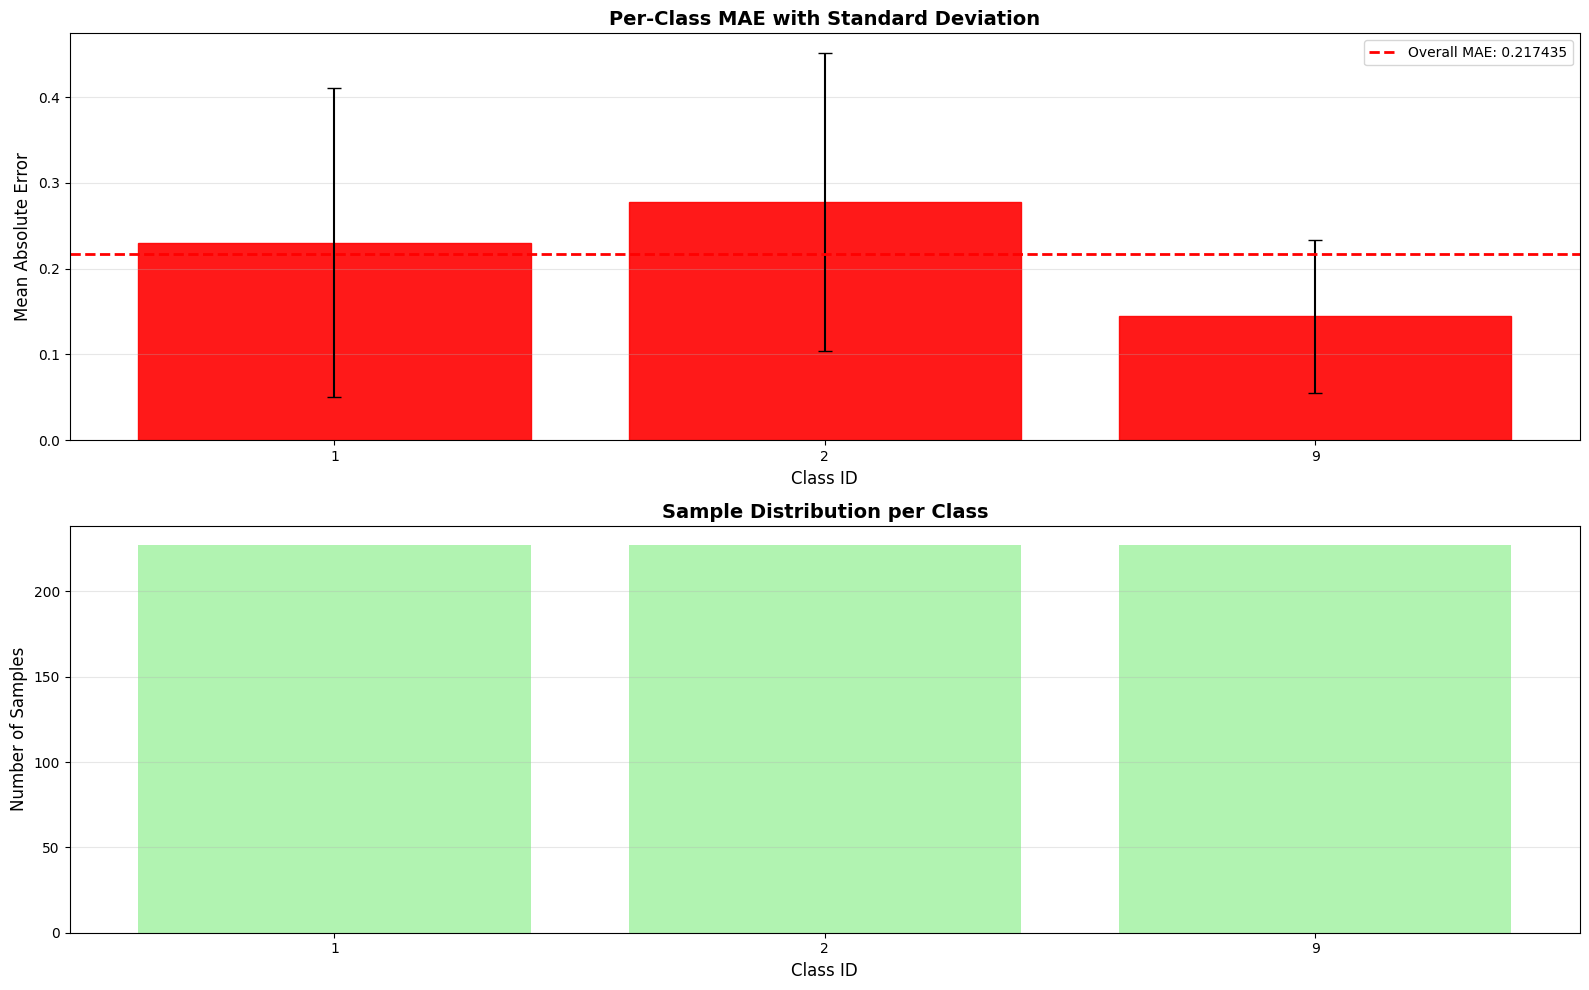


Plot saved to: /workspaces/pilot_academy/outputs/2026-01-24/16-12-12_command_vit_baseline/validation_per_class.png


In [16]:
# Prepare validation data manually
from pilot_academy.data.io import read_fn

images = []
commands = []
steering_angles = []

print("Loading validation data...")
for idx, row in df_val.iterrows():
    # Read image
    img_path = image_paths[idx]
    img = read_fn(str(img_path), grayscale=True, crop_ymin=100)
    images.append(img)
    
    # Get command
    command_id = action_to_id[row['driver_action']]
    commands.append(command_id)
    
    # Get steering angle
    steering_angles.append(row['steering_angle'])

# Convert to numpy
images = np.array(images, dtype=np.float32)
commands = np.array(commands, dtype=np.int32)
steering_angles = np.array(steering_angles, dtype=np.float32)

print(f"Images shape: {images.shape}")
print(f"Commands shape: {commands.shape}")
print(f"Steering angles shape: {steering_angles.shape}")

# Run predictions
print("\nRunning predictions...")
predictions = model.predict([images, commands], batch_size=32, verbose=1)
predictions = predictions.squeeze()

# Overall MAE
overall_mae = np.mean(np.abs(predictions - steering_angles))
print(f"\nOverall MAE: {overall_mae:.6f}")

# Per-class evaluation
print("\nPer-Class Performance:")
print("=" * 90)

id_to_label = {v: k for k, v in label_to_id.items()}
class_metrics = []

for class_id in sorted(df_val['class_id'].unique()):
    # Get indices for this class
    class_mask = df_val['class_id'].values == class_id
    
    # Get predictions and ground truth for this class
    class_preds = predictions[class_mask]
    class_gt = steering_angles[class_mask]
    
    # Calculate metrics
    class_errors = np.abs(class_preds - class_gt)
    mae = np.mean(class_errors)
    std = np.std(class_errors)
    rmse = np.sqrt(np.mean(class_errors ** 2))
    n_samples = len(class_errors)
    
    # Get label
    if class_id in id_to_label:
        road_context, driver_action = id_to_label[class_id]
        label = f"{road_context} | {driver_action}"
    else:
        label = f"Class {class_id}"
    
    class_metrics.append({
        'class_id': class_id,
        'label': label,
        'n_samples': n_samples,
        'mae': mae,
        'std': std,
        'rmse': rmse,
    })
    
    print(f"{label:45s} (n={n_samples:5d}): MAE={mae:.6f}, RMSE={rmse:.6f}, STD={std:.6f}")

# Create metrics dataframe
metrics_df = pd.DataFrame(class_metrics)

# Show worst performing classes
print("\n" + "=" * 90)
print("Top 5 WORST performing classes:")
print("=" * 90)
worst = metrics_df.nlargest(5, 'mae')
for _, row in worst.iterrows():
    print(f"{row['label']:45s}: MAE={row['mae']:.6f}")

print("\n" + "=" * 90)
print("Top 5 BEST performing classes:")
print("=" * 90)
best = metrics_df.nsmallest(5, 'mae')
for _, row in best.iterrows():
    print(f"{row['label']:45s}: MAE={row['mae']:.6f}")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: MAE per class
ax1 = axes[0]
x = np.arange(len(metrics_df))
bars = ax1.bar(x, metrics_df['mae'], yerr=metrics_df['std'], 
                capsize=5, alpha=0.7, color='steelblue')
ax1.axhline(y=overall_mae, color='red', linestyle='--', linewidth=2, label=f'Overall MAE: {overall_mae:.6f}')
ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('Mean Absolute Error', fontsize=12)
ax1.set_title('Per-Class MAE with Standard Deviation', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{row['class_id']}" for _, row in metrics_df.iterrows()])
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend()

# Highlight worst 3 classes
worst_idx = metrics_df['mae'].nlargest(3).index
for idx in worst_idx:
    bars[idx].set_color('red')
    bars[idx].set_alpha(0.9)

# Plot 2: Sample distribution
ax2 = axes[1]
ax2.bar(x, metrics_df['n_samples'], alpha=0.7, color='lightgreen')
ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Sample Distribution per Class', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{row['class_id']}" for _, row in metrics_df.iterrows()])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RUN_DIR / 'validation_per_class.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {RUN_DIR / 'validation_per_class.png'}")

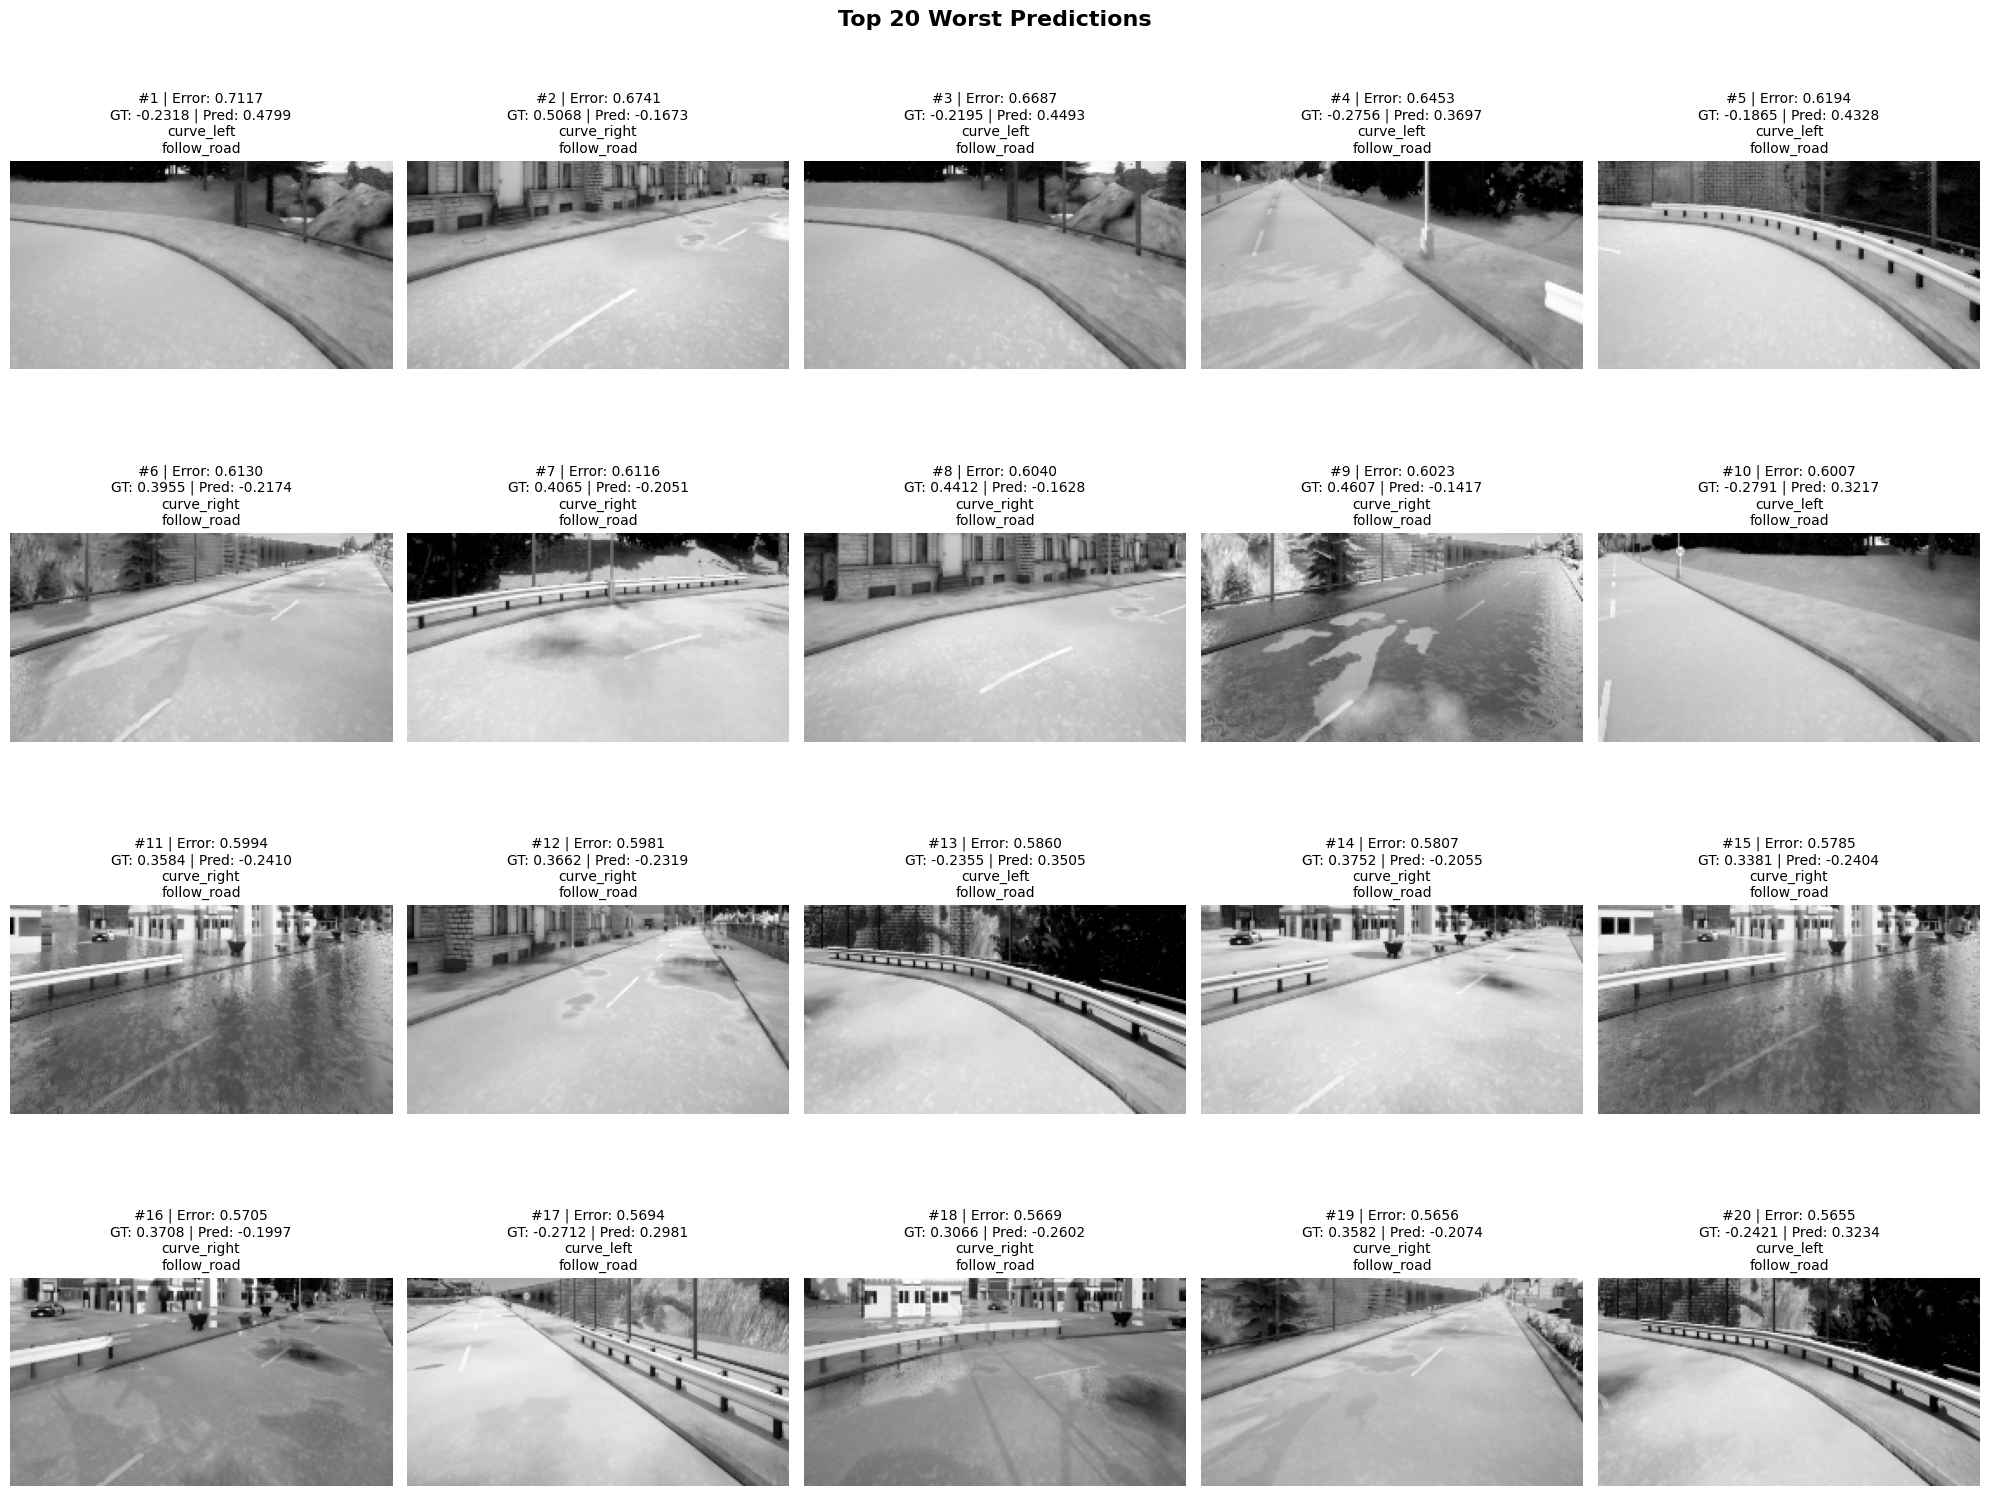


Plot saved to: /workspaces/pilot_academy/outputs/2026-01-24/16-12-12_command_vit_baseline/worst_20_predictions.png

Detailed breakdown of worst 20:
 1. Error: 0.711692 | GT: -0.2318 | Pred:  0.4799 | curve_left | follow_road | evt_0e92cRJNHk20bEnj
 2. Error: 0.674101 | GT:  0.5068 | Pred: -0.1673 | curve_right | follow_road | evt_0e92cS0pUDRue2ej
 3. Error: 0.668738 | GT: -0.2195 | Pred:  0.4493 | curve_left | follow_road | evt_0e92cRJNHk20bEnj
 4. Error: 0.645317 | GT: -0.2756 | Pred:  0.3697 | curve_left | follow_road | evt_0e92cROfxfpQTMcY
 5. Error: 0.619362 | GT: -0.1865 | Pred:  0.4328 | curve_left | follow_road | evt_0e92cRL68uivJN8u
 6. Error: 0.612953 | GT:  0.3955 | Pred: -0.2174 | curve_right | follow_road | evt_0e92cRY3vuB9tCzY
 7. Error: 0.611586 | GT:  0.4065 | Pred: -0.2051 | curve_right | follow_road | evt_0e92cQyxegDctoI1
 8. Error: 0.603954 | GT:  0.4412 | Pred: -0.1628 | curve_right | follow_road | evt_0e92cS0pUDRue2ej
 9. Error: 0.602350 | GT:  0.4607 | Pred: -0.14

In [17]:
# Get worst 20 predictions
errors = np.abs(predictions - steering_angles)
worst_indices = np.argsort(errors)[-20:][::-1]  # Top 20 worst, descending

# Create visualization
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

id_to_label = {v: k for k, v in label_to_id.items()}

for i, idx in enumerate(worst_indices):
    ax = axes[i]
    
    # Get data
    img = images[idx]
    pred = predictions[idx]
    gt = steering_angles[idx]
    error = errors[idx]
    class_id = df_val.iloc[idx]['class_id']
    command = commands[idx]
    
    # Get label
    if class_id in id_to_label:
        road_context, driver_action = id_to_label[class_id]
        label = f"{road_context}\n{driver_action}"
    else:
        label = f"Class {class_id}"
    
    # Display image (handle grayscale)
    if img.shape[-1] == 1:
        ax.imshow(img.squeeze(), cmap='gray')
    else:
        ax.imshow(img)
    
    # Add info
    ax.set_title(
        f"#{i+1} | Error: {error:.4f}\n"
        f"GT: {gt:.4f} | Pred: {pred:.4f}\n"
        f"{label}",
        fontsize=10
    )
    ax.axis('off')

plt.suptitle('Top 20 Worst Predictions', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RUN_DIR / 'worst_20_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {RUN_DIR / 'worst_20_predictions.png'}")

# Print detailed info
print("\nDetailed breakdown of worst 20:")
print("=" * 100)
for i, idx in enumerate(worst_indices):
    pred = predictions[idx]
    gt = steering_angles[idx]
    error = errors[idx]
    class_id = df_val.iloc[idx]['class_id']
    event_id = df_val.iloc[idx]['event_id']
    
    if class_id in id_to_label:
        road_context, driver_action = id_to_label[class_id]
        label = f"{road_context} | {driver_action}"
    else:
        label = f"Class {class_id}"
    
    print(f"{i+1:2d}. Error: {error:.6f} | GT: {gt:7.4f} | Pred: {pred:7.4f} | {label} | {event_id}")